***Sequential Model on basic numerical data***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    TimeSeriesSplit
)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the dataset
file_path = '/content/drive/My Drive/nlp/dataset_final/finsen_s&p500/S&P500_numerical.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())


         Date     Open    Close     High        Volume
0  2023-07-14  4514.60  4505.41  4527.75  3.647450e+09
1  2023-07-13  4491.50  4510.04  4517.37  3.839530e+09
2  2023-07-12  4467.68  4472.16  4488.33  3.920290e+09
3  2023-07-11  4415.54  4439.25  4443.64  3.624220e+09
4  2023-07-10  4394.22  4409.52  4412.60  3.429600e+09


In [5]:
# Check for missing values
print(data.isnull().sum())

# Summary statistics of the dataset
print(data.describe())


Date      0
Open      0
Close     0
High      0
Volume    0
dtype: int64
              Open        Close         High        Volume
count  4057.000000  4057.000000  4057.000000  4.057000e+03
mean   2260.863959  2261.247794  2274.083251  4.095900e+09
std    1057.433624  1057.697832  1063.027567  1.130873e+09
min     679.280000   676.530000   695.270000  1.025000e+09
25%    1356.500000  1356.780000  1364.230000  3.388540e+09
50%    2047.850000  2048.040000  2060.300000  3.857190e+09
75%    2891.910000  2888.320000  2901.910000  4.539190e+09
max    4804.500000  4796.560000  4818.620000  1.145623e+10


In [6]:
# Drop the current index and reset to default integer index
data = data.reset_index(drop=True)

# Sort the DataFrame by the 'Dates' column in ascending order
data = data.sort_values(by='Date', ascending=True)

data.head()

,Date,Open,Close,High,Volume
4056,2007-06-04,1536.28,1539.18,1540.53,2.738930e+09
4055,2007-06-05,1539.11,1530.94,1539.11,2.939450e+09
4054,2007-06-06,1530.56,1517.38,1530.56,2.964190e+09
4053,2007-06-07,1517.35,1490.71,1517.35,3.538470e+09
4052,2007-06-08,1490.70,1507.67,1507.76,2.993460e+09


In [7]:
# Calculate next-day return
data['Movement'] = ((data['Open'].shift(-1) - data['Close']) / data['Close'])

# Shift Movement to align with current day
data['Movement'] = data['Movement'].shift(1)

# Drop the last row because there's no next day to compare
data = data.dropna(subset=['Movement'])

# Convert Movement into binary (1 for up if Movement > 0, else 0)
data['Movement'] = (data['Movement'] > 0).astype(int)

# Check the distribution of the target variable
print(data['Movement'].value_counts().sort_index())

Movement
0    1990
1    2066
Name: count, dtype: int64


In [8]:
# Calculate daily returns (in percentage)
data['Daily_Return'] = data['Close'].pct_change() * 100

# Choose a rolling window (e.g., 10 days) for volatility
window_size = 5
data['Volatility'] = data['Daily_Return'].rolling(window=window_size).std()

# Drop the initial NaNs from rolling calculation
data = data.dropna(subset=['Volatility'])

In [9]:
# Create lagged features to avoid data leakage
data['Close_lag1'] = data['Close'].shift(1)
data['High_lag1'] = data['High'].shift(1)
data['Volume_lag1'] = data['Volume'].shift(1)
data['Daily_Return_lag1'] = data['Daily_Return'].shift(1)
data['Volatility_lag1'] = data['Volatility'].shift(1)

# Drop rows with NaN values introduced by shifting
data = data.dropna(subset=['Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1'])


In [10]:
data.tail(20)


,Date,Open,Close,High,Volume,Movement,Daily_Return,Volatility,Close_lag1,High_lag1,Volume_lag1,Daily_Return_lag1,Volatility_lag1
19,2023-06-15,4365.33,4425.83,4439.20,4.176690e+09,0,1.217816,0.501125,4372.58,4391.81,4.252110e+09,0.081941,0.374475
18,2023-06-16,4440.95,4409.58,4448.47,6.848600e+09,1,-0.367163,0.645274,4425.83,4439.20,4.176690e+09,1.217816,0.501125
17,2023-06-20,4396.10,4388.70,4400.14,4.055790e+09,0,-0.473514,0.718268,4409.58,4448.47,6.848600e+09,-0.367163,0.645274
16,2023-06-21,4380.00,4365.68,4386.22,3.709330e+09,0,-0.524529,0.728541,4388.70,4400.14,4.055790e+09,-0.473514,0.718268
15,2023-06-22,4355.39,4381.89,4382.25,3.511000e+09,0,0.371305,0.749178,4365.68,4386.22,3.709330e+09,-0.524529,0.728541
14,2023-06-23,4354.16,4348.33,4366.54,6.053620e+09,0,-0.765880,0.429892,4381.89,4382.25,3.511000e+09,0.371305,0.749178
13,2023-06-26,4344.83,4328.81,4362.06,3.415030e+09,0,-0.448908,0.432163,4348.33,4366.54,6.053620e+09,-0.765880,0.429892
12,2023-06-27,4337.35,4378.41,4384.41,3.573500e+09,1,1.145811,0.791217,4328.81,4362.06,3.415030e+09,-0.448908,0.432163
11,2023-06-28,4367.47,4376.85,4390.35,3.739330e+09,0,-0.035629,0.745970,4378.41,4384.41,3.573500e+09,1.145811,0.791217
10,2023-06-29,4374.93,4396.43,4398.39,3.696660e+09,0,0.447354,0.754797,4376.85,4390.35,3.739330e+09,-0.035629,0.745970


In [11]:
data.columns

Index(['Date', 'Open', 'Close', 'High', 'Volume', 'Movement', 'Daily_Return',
       'Volatility', 'Close_lag1', 'High_lag1', 'Volume_lag1',
       'Daily_Return_lag1', 'Volatility_lag1'],
      dtype='object')

In [12]:
# Correlation Metrics
# Specify the columns of interest for correlation with 'Movement'
columns_of_interest = ['Open', 'Close_lag1', 'High_lag1', 'Volume_lag1',
                        'Daily_Return_lag1', 'Volatility_lag1']

# Calculate the correlation between 'Movement' and each of the specified columns
correlation_with_movement = data[columns_of_interest + ['Movement']].corr()['Movement']

# Drop the self-correlation of 'Movement'
correlation_with_movement = correlation_with_movement.drop('Movement')

# Display the correlation values
print(correlation_with_movement)


Open                 0.082004
Close_lag1           0.076679
High_lag1            0.076844
Volume_lag1         -0.003639
Daily_Return_lag1   -0.073555
Volatility_lag1     -0.028720
Name: Movement, dtype: float64


In [13]:
# Define features (X) and target (y)
features = ['Open', 'Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1']
X = data[features]
y = data['Movement']

# Inspect the feature set
print(X.head())
print(y.head())


         Open  Close_lag1  High_lag1   Volume_lag1  Daily_Return_lag1  \
4049  1492.65     1493.00    1511.32  3.056200e+09          -1.067517   
4048  1515.57     1515.67    1515.69  3.077930e+09           1.518419   
4047  1522.96     1522.96    1526.44  2.813630e+09           0.480975   
4046  1532.90     1532.91    1538.70  3.406030e+09           0.653333   
4045  1531.02     1531.05    1535.43  2.480240e+09          -0.121338   

      Volatility_lag1  
4049         1.127957  
4048         1.399723  
4047         1.005299  
4046         0.941744  
4045         0.960405  
4049    0
4048    0
4047    0
4046    0
4045    0
Name: Movement, dtype: int64


In [14]:
# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])  # Ensure correct datetime format
data.set_index('Date', inplace=True)
print(data.index)


DatetimeIndex(['2007-06-13', '2007-06-14', '2007-06-15', '2007-06-18',
               '2007-06-19', '2007-06-20', '2007-06-21', '2007-06-22',
               '2007-06-25', '2007-06-26',
               ...
               '2023-06-30', '2023-07-03', '2023-07-05', '2023-07-06',
               '2023-07-07', '2023-07-10', '2023-07-11', '2023-07-12',
               '2023-07-13', '2023-07-14'],
              dtype='datetime64[ns]', name='Date', length=4050, freq=None)


In [15]:
X.index = data.index
print(X.index)

DatetimeIndex(['2007-06-13', '2007-06-14', '2007-06-15', '2007-06-18',
               '2007-06-19', '2007-06-20', '2007-06-21', '2007-06-22',
               '2007-06-25', '2007-06-26',
               ...
               '2023-06-30', '2023-07-03', '2023-07-05', '2023-07-06',
               '2023-07-07', '2023-07-10', '2023-07-11', '2023-07-12',
               '2023-07-13', '2023-07-14'],
              dtype='datetime64[ns]', name='Date', length=4050, freq=None)


In [16]:
# Initialize TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5)
# Initialize lists to store train and test years
train_years = []
test_years = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Map the integer indices back to the DatetimeIndex
    train_dates = X.index[train_index]
    test_dates = X.index[test_index]

    # Store the dates
    train_years.append(train_dates)
    test_years.append(test_dates)

    # Print the date range for each fold (optional)
    print(f"Fold {fold + 1}:")
    print(f"Train Dates: {train_dates.min().strftime('%Y-%m-%d')} to {train_dates.max().strftime('%Y-%m-%d')}")
    print(f"Test Dates: {test_dates.min().strftime('%Y-%m-%d')} to {test_dates.max().strftime('%Y-%m-%d')}")
    print("-" * 50)


Fold 1:
Train Dates: 2007-06-13 to 2010-02-16
Test Dates: 2010-02-17 to 2012-10-17
--------------------------------------------------
Fold 2:
Train Dates: 2007-06-13 to 2012-10-17
Test Dates: 2012-10-18 to 2015-06-26
--------------------------------------------------
Fold 3:
Train Dates: 2007-06-13 to 2015-06-26
Test Dates: 2015-06-29 to 2018-03-02
--------------------------------------------------
Fold 4:
Train Dates: 2007-06-13 to 2018-03-02
Test Dates: 2018-03-05 to 2020-11-04
--------------------------------------------------
Fold 5:
Train Dates: 2007-06-13 to 2020-11-04
Test Dates: 2020-11-05 to 2023-07-14
--------------------------------------------------


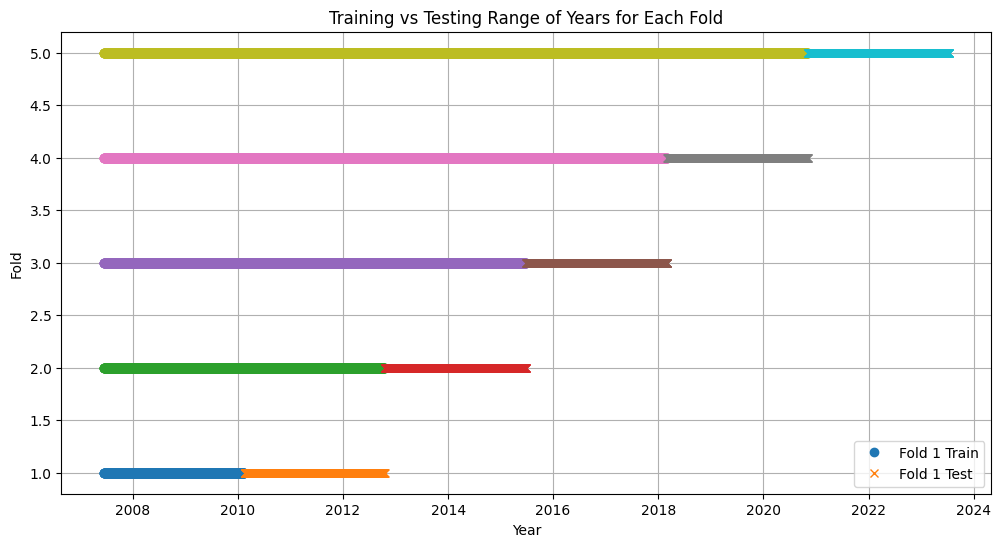

In [17]:
# Plot training vs testing years
plt.figure(figsize=(12, 6))

for i, (train, test) in enumerate(zip(train_years, test_years)):
    plt.plot(train, [i + 1] * len(train), 'o', label=f'Fold {i + 1} Train' if i == 0 else "")
    plt.plot(test, [i + 1] * len(test), 'x', label=f'Fold {i + 1} Test' if i == 0 else "")

plt.xlabel('Year')
plt.ylabel('Fold')
plt.title('Training vs Testing Range of Years for Each Fold')
plt.legend(loc='lower right')
plt.grid()
plt.savefig('training_vs_testing_years.png')
plt.show()


***Model training and evaluation***

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 1 Confusion Matrix:
[[293  65]
 [223  94]]


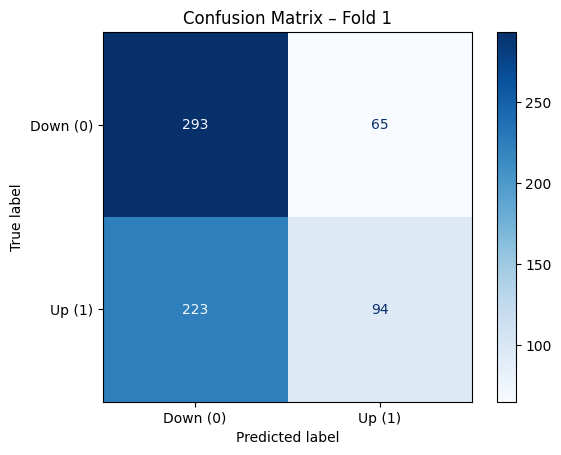

Fold 1 Accuracy: 0.57
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Fold 2 Confusion Matrix:
[[345   1]
 [329   0]]


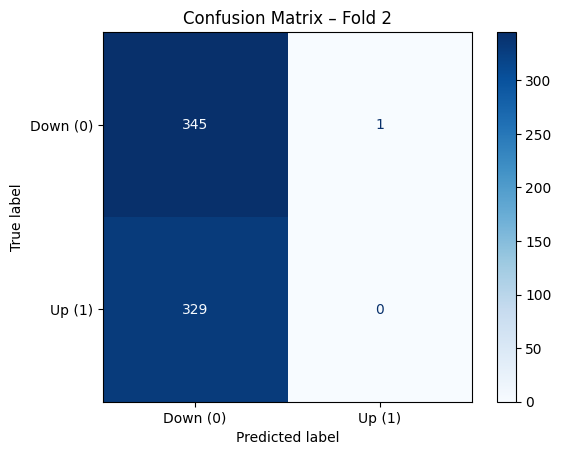

Fold 2 Accuracy: 0.51
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 3 Confusion Matrix:
[[ 13 285]
 [  9 368]]


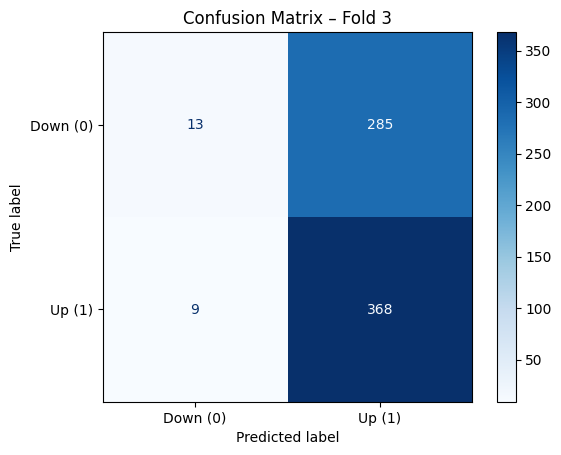

Fold 3 Accuracy: 0.56
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 4 Confusion Matrix:
[[  9 272]
 [  4 390]]


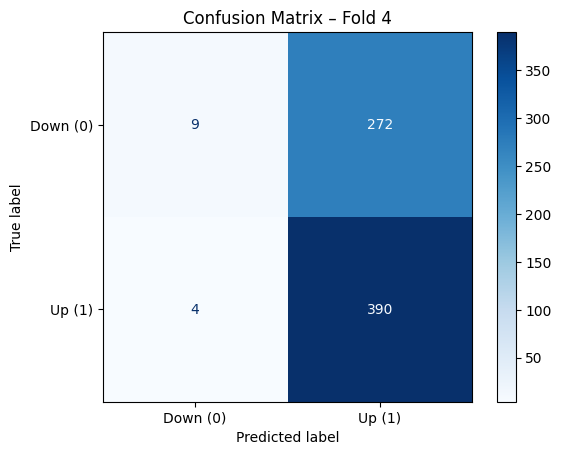

Fold 4 Accuracy: 0.59
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 5 Confusion Matrix:
[[  0 315]
 [  0 360]]


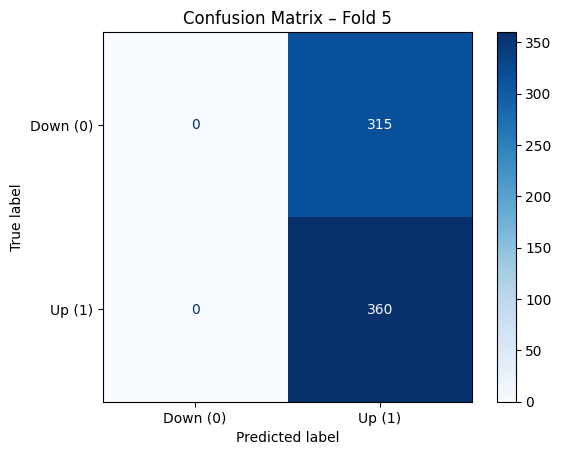

Fold 5 Accuracy: 0.53
--------------------------------------------------

Average Metrics Across Folds (Deep-Learning_Unbalanced):
Accuracy : 0.55
Precision: 0.46
Recall   : 0.65
F1-Score : 0.51
ROC-AUC  : 0.53


In [18]:
# Lists to collect metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# TimeSeries split
tss = TimeSeriesSplit(n_splits=5)

for fold, (train_idx, test_idx) in enumerate(tss.split(X), 1):
    # 1) Split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # 2) Scale features
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # 3) Build a small Keras model
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_s.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # 4) Fit with early stopping
    es = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    history = model.fit(
        X_train_s, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )

    # 5) Predict probabilities and classes
    y_prob = model.predict(X_test_s).flatten()
    y_pred = (y_prob >= 0.5).astype(int)

    # 6) Compute metrics
    acc   = accuracy_score(y_test, y_pred)
    prec  = precision_score(y_test, y_pred, zero_division=0)
    rec   = recall_score(y_test, y_pred, zero_division=0)
    f1    = f1_score(y_test, y_pred, zero_division=0)
    auc   = roc_auc_score(y_test, y_prob)

    accuracy_scores.append(acc)
    precision_scores.append(prec)
    recall_scores.append(rec)
    f1_scores.append(f1)
    roc_auc_scores.append(auc)

    # 7) Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold} Confusion Matrix:\n{cm}")
    disp = ConfusionMatrixDisplay(cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(f"Confusion Matrix – Fold {fold}")
    plt.savefig(f"confusion_matrix_dl_unbalanced_fold_{fold}.png")
    plt.show()

    print(f"Fold {fold} Accuracy: {acc:.2f}\n" + "-"*50)

# 8) Average metrics
print("\nAverage Metrics Across Folds (Deep-Learning_Unbalanced):")
print(f"Accuracy : {np.mean(accuracy_scores):.2f}")
print(f"Precision: {np.mean(precision_scores):.2f}")
print(f"Recall   : {np.mean(recall_scores):.2f}")
print(f"F1-Score : {np.mean(f1_scores):.2f}")
print(f"ROC-AUC  : {np.mean(roc_auc_scores):.2f}")


***Balanced Data***

Fold 1 — balanced training distribution:
Movement
0    289
1    289
Name: count, dtype: int64
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 1 Confusion Matrix:
[[358   0]
 [317   0]]


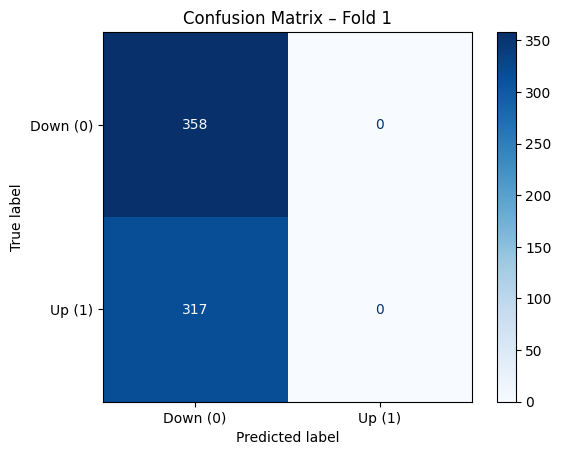

Fold 1 Accuracy: 0.53
--------------------------------------------------
Fold 2 — balanced training distribution:
Movement
0    606
1    606
Name: count, dtype: int64
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Fold 2 Confusion Matrix:
[[346   0]
 [329   0]]


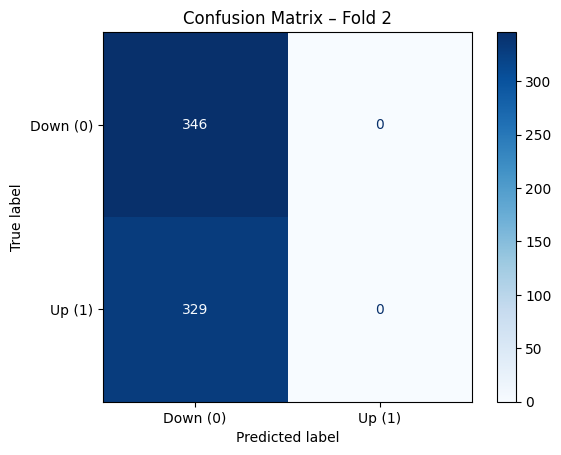

Fold 2 Accuracy: 0.51
--------------------------------------------------
Fold 3 — balanced training distribution:
Movement
0    935
1    935
Name: count, dtype: int64
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3 Confusion Matrix:
[[298   0]
 [377   0]]


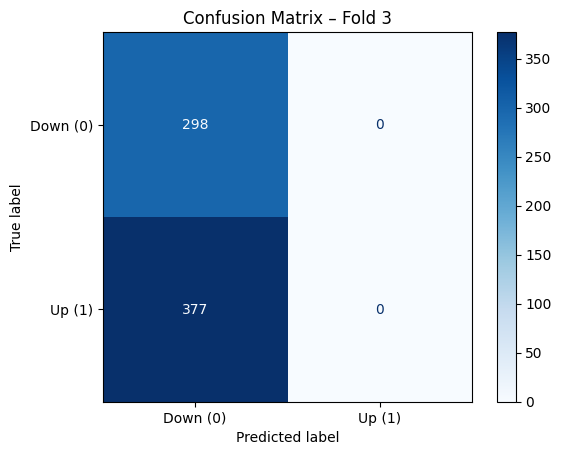

Fold 3 Accuracy: 0.44
--------------------------------------------------
Fold 4 — balanced training distribution:
Movement
0    1312
1    1312
Name: count, dtype: int64
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 4 Confusion Matrix:
[[281   0]
 [394   0]]


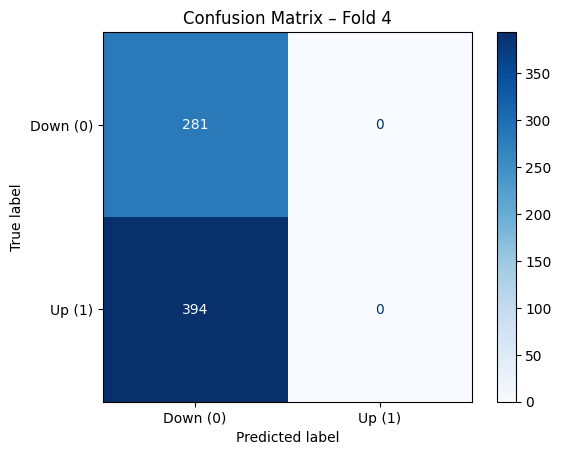

Fold 4 Accuracy: 0.42
--------------------------------------------------
Fold 5 — balanced training distribution:
Movement
0    1669
1    1669
Name: count, dtype: int64
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 5 Confusion Matrix:
[[173 142]
 [211 149]]


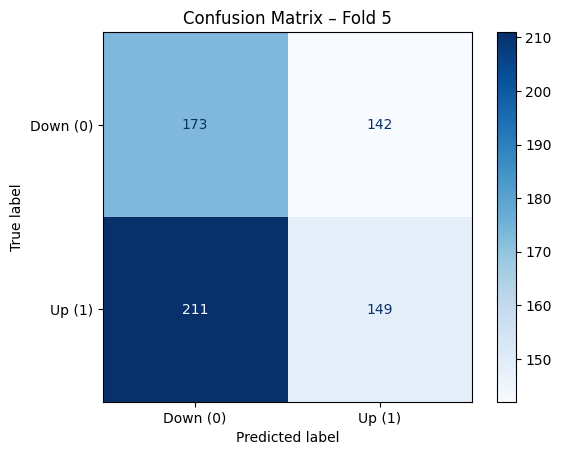

Fold 5 Accuracy: 0.48
--------------------------------------------------

Average Metrics Across Folds (Deep-Learning_Balanced):
Accuracy :  0.48
Precision:  0.10
Recall   :  0.08
F1-Score :  0.09
ROC-AUC  :  0.48


In [19]:
# Initialize RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)

# Lists to collect metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# TimeSeries split
tss = TimeSeriesSplit(n_splits=5)

for fold, (train_idx, test_idx) in enumerate(tss.split(X), 1):
    # 1) Split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # 2) Undersample only the training data
    X_train_bal, y_train_bal = undersampler.fit_resample(X_train, y_train)
    print(f"Fold {fold} — balanced training distribution:\n{y_train_bal.value_counts()}\n" + "-"*50)

    # 3) Scale features
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train_bal)
    X_test_s  = scaler.transform(X_test)

    # 4) Build a small Keras model
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_s.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # 5) Fit with early stopping
    es = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    history = model.fit(
        X_train_s, y_train_bal,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )

    # 6) Predict probabilities and classes
    y_prob = model.predict(X_test_s).flatten()
    y_pred = (y_prob >= 0.5).astype(int)

    # 7) Compute metrics
    acc   = accuracy_score(y_test, y_pred)
    prec  = precision_score(y_test, y_pred, zero_division=0)
    rec   = recall_score(y_test, y_pred, zero_division=0)
    f1    = f1_score(y_test, y_pred, zero_division=0)
    auc   = roc_auc_score(y_test, y_prob)

    accuracy_scores.append(acc)
    precision_scores.append(prec)
    recall_scores.append(rec)
    f1_scores.append(f1)
    roc_auc_scores.append(auc)

    # 8) Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold} Confusion Matrix:\n{cm}")
    disp = ConfusionMatrixDisplay(cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(f"Confusion Matrix – Fold {fold}")
    plt.savefig(f"confusion_matrix_dl_balanced_fold_{fold}.png")
    plt.show()

    print(f"Fold {fold} Accuracy: {acc:.2f}\n" + "-"*50)

# 9) Average metrics
print("\nAverage Metrics Across Folds (Deep-Learning_Balanced):")
print(f"Accuracy : {np.mean(accuracy_scores) : .2f}")
print(f"Precision: {np.mean(precision_scores): .2f}")
print(f"Recall   : {np.mean(recall_scores)   : .2f}")
print(f"F1-Score : {np.mean(f1_scores)        : .2f}")
print(f"ROC-AUC  : {np.mean(roc_auc_scores)   : .2f}")
